In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']="0"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'

import jax, flax, optax
import jax.numpy as jnp
from flax.linen.module import Module, compact
from flax.linen.initializers import zeros_init, normal, xavier_normal
from jax import random
import numpy as np
from matplotlib import pyplot as plt
import uuid

In [2]:
class LowRankQUBO(Module):
    Rank: int
    
    @compact
    def __call__(me, x):
        Bs, Ch = x.shape
        Rank = me.Rank
        V = me.param('V', xavier_normal(), (Ch,Rank), jnp.float32)
        b = me.param('b', zeros_init(), (Ch,), jnp.float32)
        a = me.param('a', zeros_init(), (1,), jnp.float32)
        W = jnp.matmul( V, V.T) # Ch x Ch

        a_batch = a.reshape(1)
        b_batch = b.reshape(1,Ch)
        W_batch = W.reshape(1,Ch,Ch)
        
        xij_batch = x.reshape(Bs,1,Ch) * x.reshape(Bs,Ch,1)

        res = a_batch + (b_batch*x).sum(axis=1) + (xij_batch * W_batch).sum(axis=(1,2))
        return res

In [3]:
R = 4
BpR = 101

xl = np.linspace(-1,1,BpR)
yl = xl.copy()
zl = xl.copy()
wl = xl.copy()

In [4]:
from functools import lru_cache
#@lru_cache(maxsize = None)
def get_loss(pid):     
    ovec = [(pid//BpR//BpR//BpR)%BpR,(pid//BpR//BpR)%BpR,(pid//BpR)%BpR,(pid)%BpR] ###############
    x,y,z,w = xl[ovec[0]], yl[ovec[1]], zl[ovec[2]], wl[ovec[3]]
    return np.sqrt(x**2+y**2+z**2+w**2)

def get_sample(pid): #dim=R, range=(0,BpR-1)
    ovec = [(pid//BpR//BpR//BpR)%BpR,(pid//BpR//BpR)%BpR,(pid//BpR)%BpR,(pid)%BpR] ###############
    x,y,z,w = xl[ovec[0]], yl[ovec[1]], zl[ovec[2]], wl[ovec[3]]
    yvec = np.array([x,y,z,w],dtype=np.float32)
    xvec = np.zeros([R,BpR] , dtype=np.float32)
    for i, o in enumerate(ovec):
        xvec[i,o] = 1.
    ans = get_loss( pid )
    return xvec.flatten(), ans, yvec

In [5]:
def learn_FMQA(dataset_x, dataset_t, SRcoef, Rank):

    def loss(params, x, t):
        y = model.apply(params, x)
        L1 = ((t-y)**2).sum()
    
        V = params['params']['V']
        Vpk = V.reshape(R,BpR,-1) #  i, pi, rank
        B = params['params']['b']
        Bpk = B.reshape(R,BpR)
    
        Vpk_d = jnp.square(Vpk[:,1:,:] - Vpk[:,:-1,:])
        Bpk_d = jnp.square(Bpk[:,1:] - Bpk[:,:-1])
        L2 = jnp.sum(Vpk_d) + jnp.sum(Bpk_d)
        return L1 + SRcoef*L2

    loss_grad_fn = jax.value_and_grad(loss)
    
    model = LowRankQUBO(Rank = Rank)
    Ch = R*BpR
    key1, key2 = random.split(random.PRNGKey(173))
    x = random.normal(key1, (7,Ch))
    params = model.init(key2, x)
    
    tx = optax.amsgrad(learning_rate=1e-1)
    opt_state = tx.init(params)
    
    loss_li = []
    l2_li = []
    
    for loop in range(500):
        x, t = np.array(dataset_x), np.array(dataset_t)
        loss_val, grads = loss_grad_fn(params, x, t)
        updates, opt_state = tx.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        loss_li.append( np.array(loss_val) )
    
    
        V = np.array(params['params']['V'])
        Vpk = V.reshape(R,BpR,-1)
        Vpk_d = np.square(Vpk[:,1:,:] - Vpk[:,:-1,:])
        l2_li.append( np.sum(Vpk_d) )
    
        print (end="#", flush = True) if loop%100 == 0 else None
    #plt.figure(figsize=(4,2))
    #plt.semilogy(loss_li)
    return model, params

## Dnum : Number of input data, SR: Strength of FSR, Rank : FM rank 

Dnum 10 SR 0 Rank 4
#####

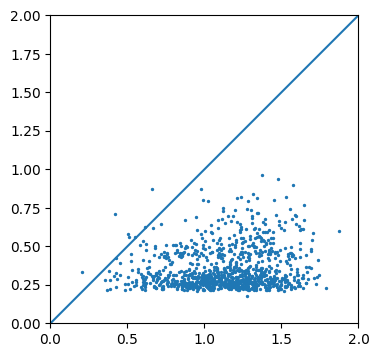

Dnum 10 SR 0.1 Rank 4
#####

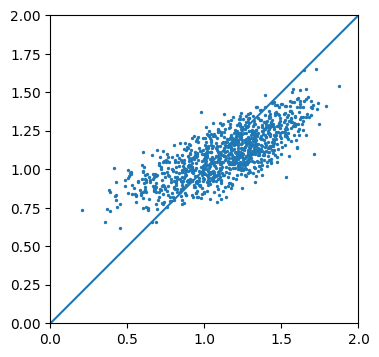

Dnum 10 SR 1.0 Rank 4
#####

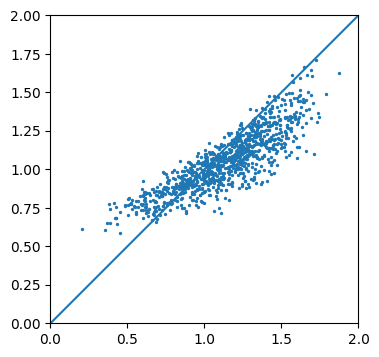

Dnum 10 SR 10.0 Rank 4
#####

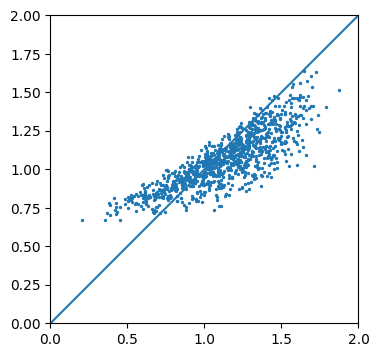

Dnum 10 SR 0 Rank 16
#####

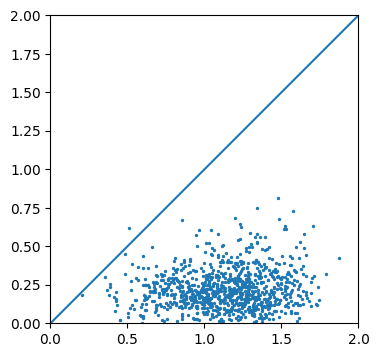

Dnum 10 SR 0.1 Rank 16
#####

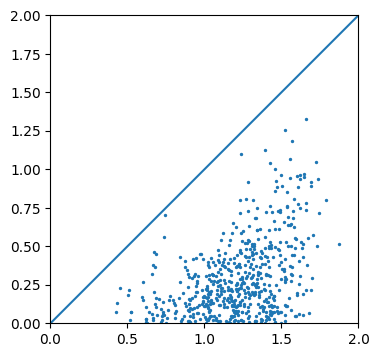

Dnum 10 SR 1.0 Rank 16
#####

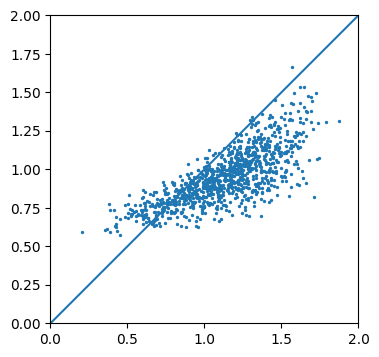

Dnum 10 SR 10.0 Rank 16
#####

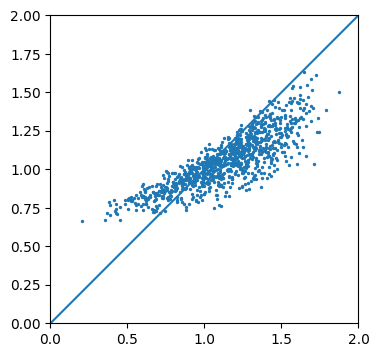

Dnum 10 SR 0 Rank 64
#####

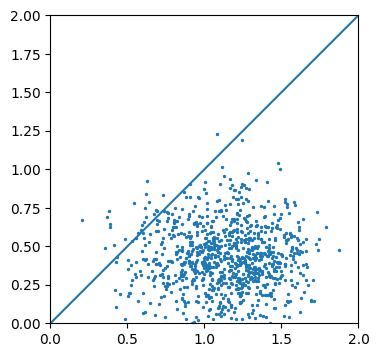

Dnum 10 SR 0.1 Rank 64
#####

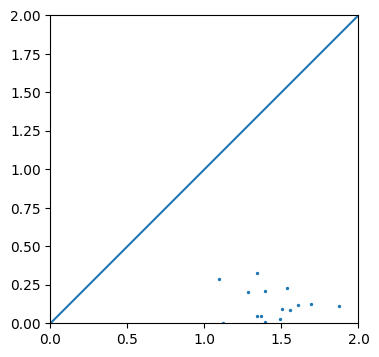

Dnum 10 SR 1.0 Rank 64
#####

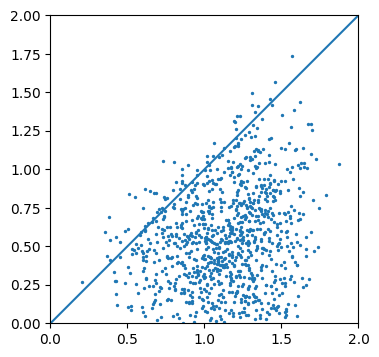

Dnum 10 SR 10.0 Rank 64
#####

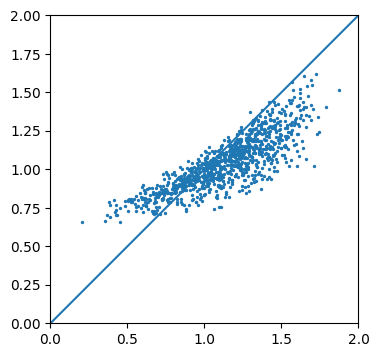

Dnum 50 SR 0 Rank 4
#####

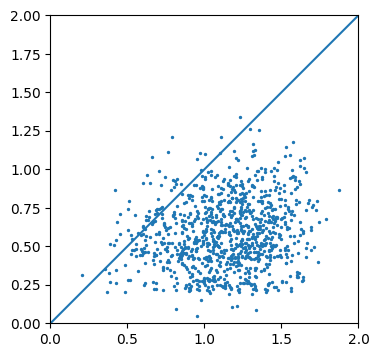

Dnum 50 SR 0.1 Rank 4
#####

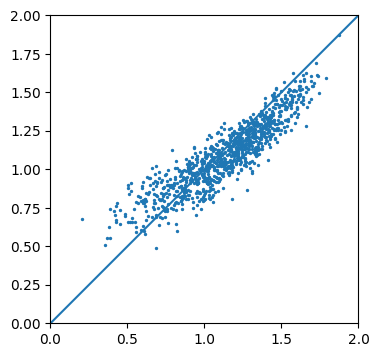

Dnum 50 SR 1.0 Rank 4
#####

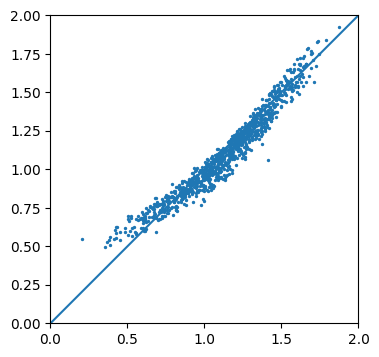

Dnum 50 SR 10.0 Rank 4
#####

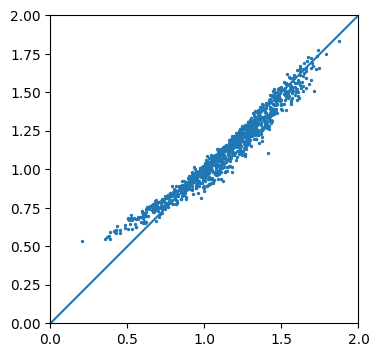

Dnum 50 SR 0 Rank 16
#####

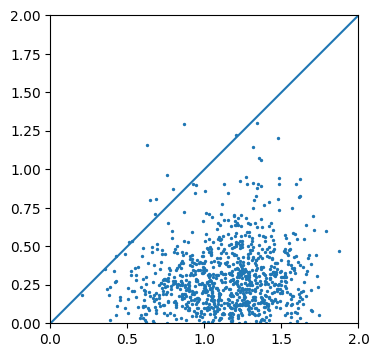

Dnum 50 SR 0.1 Rank 16
#####

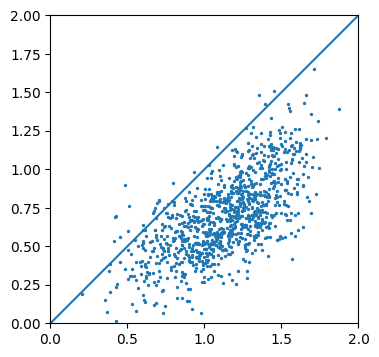

Dnum 50 SR 1.0 Rank 16
#####

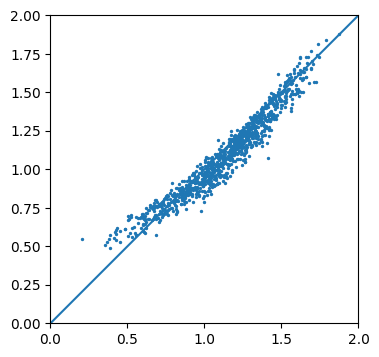

Dnum 50 SR 10.0 Rank 16
#####

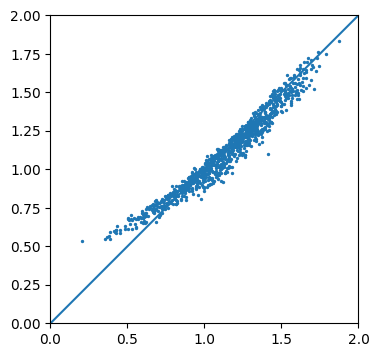

Dnum 50 SR 0 Rank 64
#####

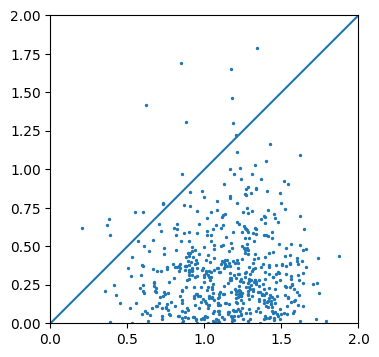

Dnum 50 SR 0.1 Rank 64
#####

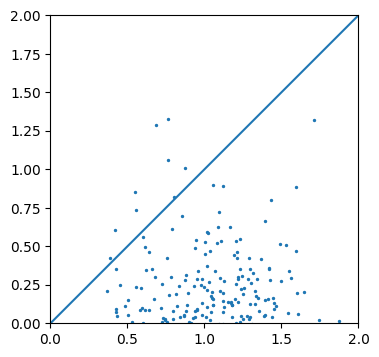

Dnum 50 SR 1.0 Rank 64
#####

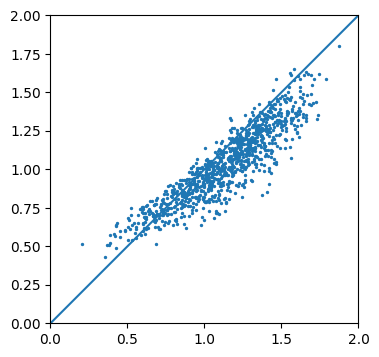

Dnum 50 SR 10.0 Rank 64
#####

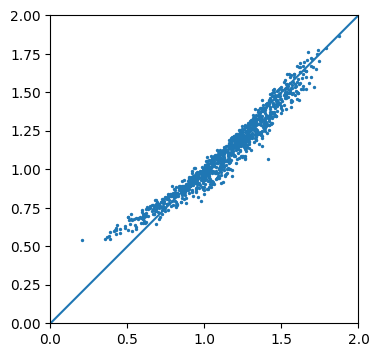

Dnum 100 SR 0 Rank 4
#####

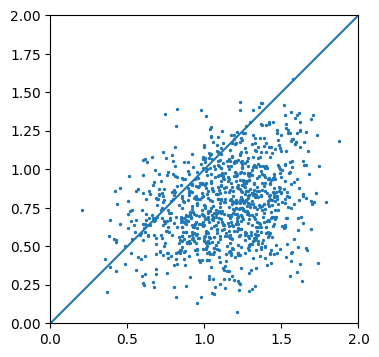

Dnum 100 SR 0.1 Rank 4
#####

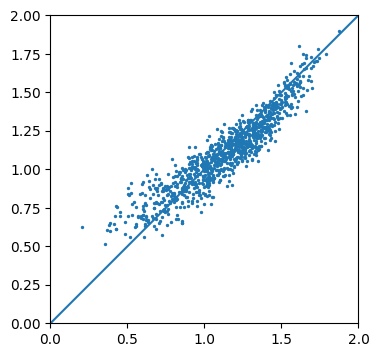

Dnum 100 SR 1.0 Rank 4
#####

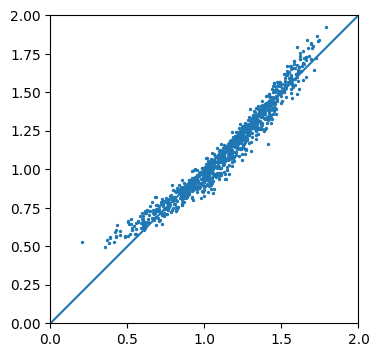

Dnum 100 SR 10.0 Rank 4
#####

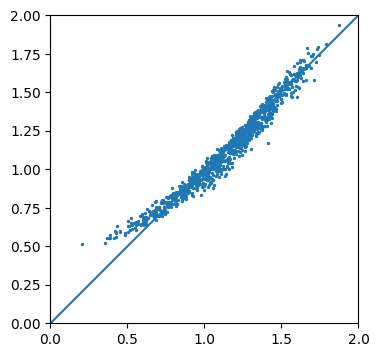

Dnum 100 SR 0 Rank 16
#####

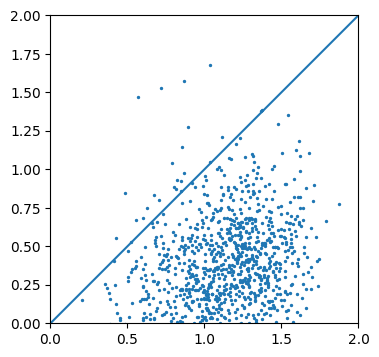

Dnum 100 SR 0.1 Rank 16
#####

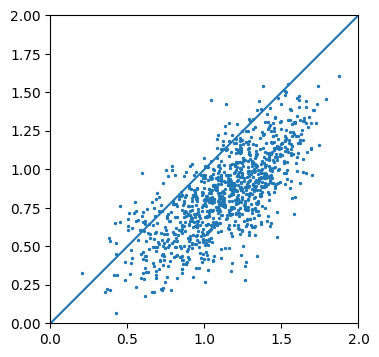

Dnum 100 SR 1.0 Rank 16
#####

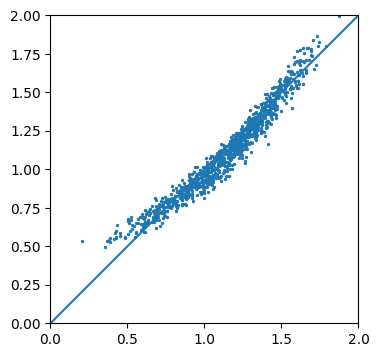

Dnum 100 SR 10.0 Rank 16
#####

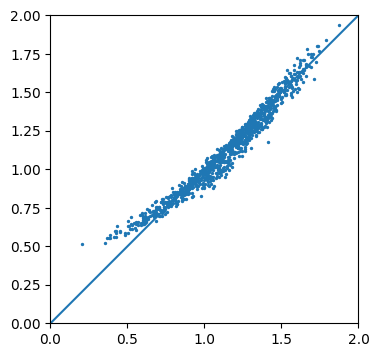

Dnum 100 SR 0 Rank 64
#####

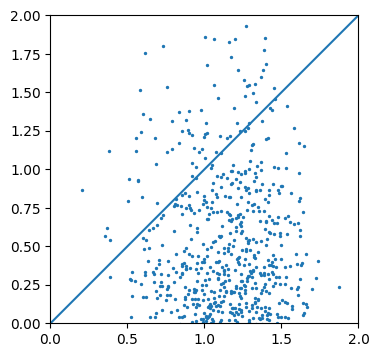

Dnum 100 SR 0.1 Rank 64
#####

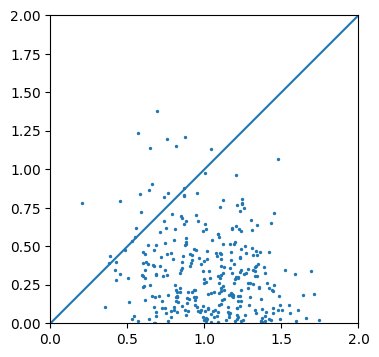

Dnum 100 SR 1.0 Rank 64
#####

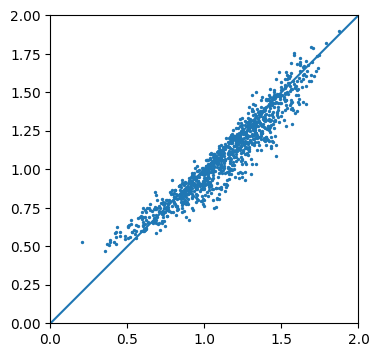

Dnum 100 SR 10.0 Rank 64
#####

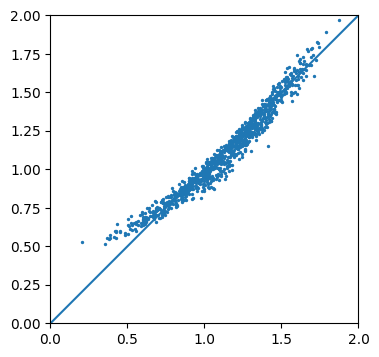

Dnum 500 SR 0 Rank 4
#####

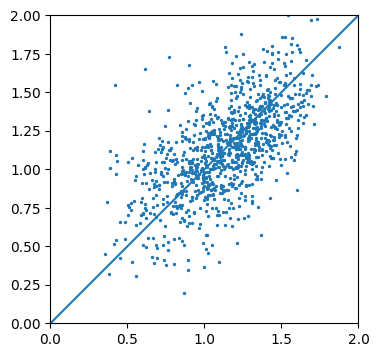

Dnum 500 SR 0.1 Rank 4
#####

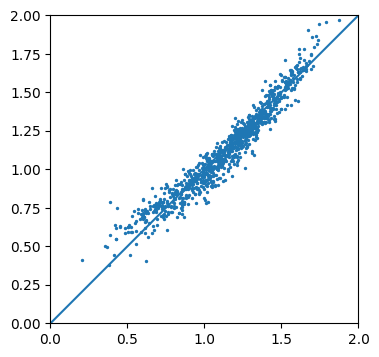

Dnum 500 SR 1.0 Rank 4
#####

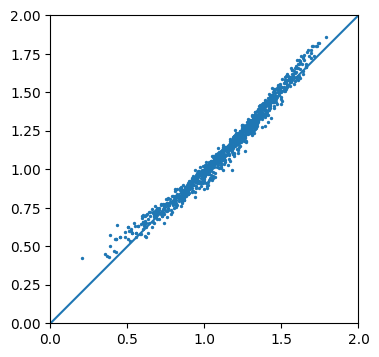

Dnum 500 SR 10.0 Rank 4
#####

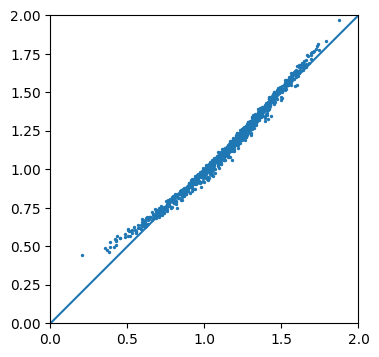

Dnum 500 SR 0 Rank 16
#####

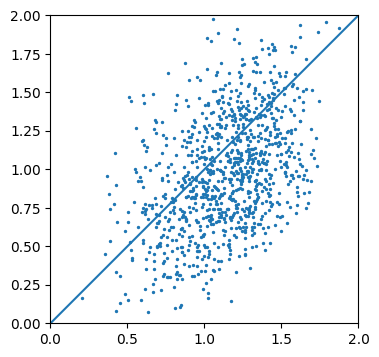

Dnum 500 SR 0.1 Rank 16
#####

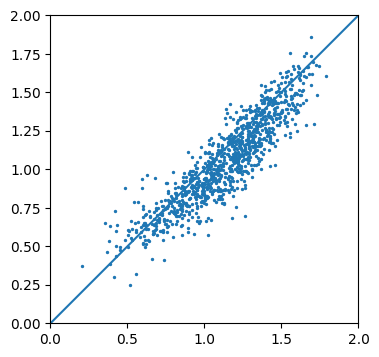

Dnum 500 SR 1.0 Rank 16
#####

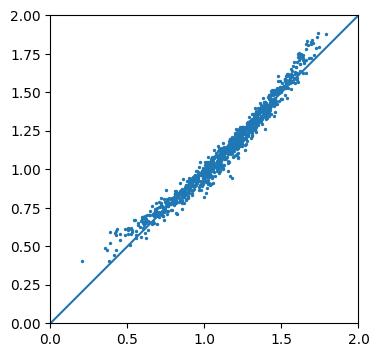

Dnum 500 SR 10.0 Rank 16
#####

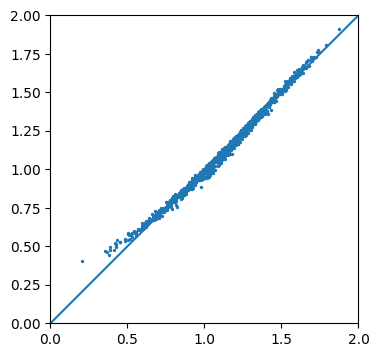

Dnum 500 SR 0 Rank 64
#####

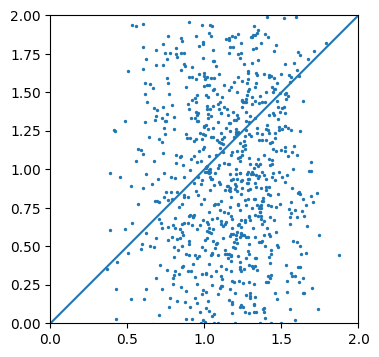

Dnum 500 SR 0.1 Rank 64
#####

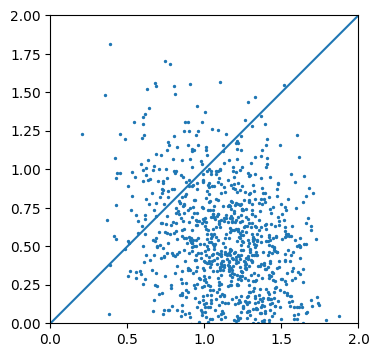

Dnum 500 SR 1.0 Rank 64
#####

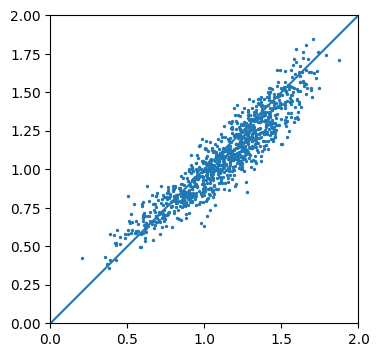

Dnum 500 SR 10.0 Rank 64
#####

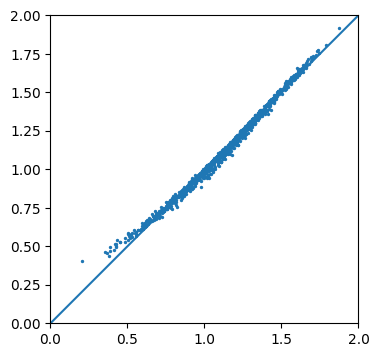

Dnum 1000 SR 0 Rank 4
####

In [ ]:
for num in [10, 50, 100, 500, 1000]:
    for Rank in [4,16,64]:
        for SRcoef in [0, 0.1, 1.0, 10.0]:
        
            print ("Dnum", num, "SR", SRcoef, "Rank", Rank )
            dataset_x, dataset_t, dataset_c= [], [], []
            
            np.random.seed(137)
            for i in range(num):
                pid = np.random.randint( BpR**R )
                xv, t, cv = get_sample(pid)
                dataset_x.append(xv)
                dataset_t.append(t)
                dataset_c.append(cv)
            
            model, params = learn_FMQA(dataset_x, dataset_t, SRcoef, Rank) 
            
            test_x, test_t, test_c= [], [], []
            
            np.random.seed(42)
            for i in range(1000):
                pid = np.random.randint( BpR**R )
                xv, t, cv = get_sample(pid)
                test_x.append(xv)
                test_t.append(t)
                test_c.append(cv)
            
            yp = model.apply(params, np.array(test_x) )
            xnrm = np.linalg.norm(np.array(test_c),axis=1)

            filename = str(uuid.uuid4())+".npz"
            #arg = {"num":num, "Rank":Rank, "SRcoef":SRcoef}
            #np.savez("data/"+filename, dataset_x=dataset_x,dataset_t=dataset_t,dataset_c=dataset_c, test_x=test_x, test_t=test_t, test_c=test_c, yp=yp, arg=arg )
            
            plt.figure(figsize=(4,4))
            plt.plot( [0,2], [0,2])
            plt.scatter( xnrm, yp, s=2)
            plt.axis("square")
            plt.xlim(0,2)
            plt.ylim(0,2)
            plt.show()